In [1]:
import sys
import math

import numpy

import astropy
from astropy import units as u

from glue.ligolw import utils, lsctables, ligolw
lsctables.use_in(ligolw.LIGOLWContentHandler)
from pylal.series import read_psd_xmldoc, make_psd_xmldoc
from pylal import series

import matplotlib
%matplotlib inline
from matplotlib import pyplot

import scipy.stats

import lal, lalburst
from lalsimulation import SimBurstSineGaussian, SimBurstSineGaussianDuration, SimBurstSineGaussianQ, \
                            GenerateBandAndTimeLimitedWhiteNoiseBurst

from gwpy.spectrum import Spectrum
from gwpy.timeseries import TimeSeries

## Utility functions

These are all drawn and/or modified from their versions in `pyburst_excesspower`. See https://github.com/cpankow/pyburst

In [2]:
def generate_wnb(dur, band, freq, amp, dt=1./4096, rnd=0,):
    """
    Technical work around because we still don't expose the gsl rng object.
    *grumble, mutter, grumble*
    """
    import lalmetaio
    wnb_sim = lalmetaio.SimBurst()
    wnb_sim.waveform = "BTLWNB"
    wnb_sim.frequency = freq
    wnb_sim.bandwidth = band
    wnb_sim.egw_over_rsquared = amp
    wnb_sim.time_geocent_gps = int(1e9)
    wnb_sim.time_geocent_gps_ns = 0.0
    wnb_sim.duration = dur
    wnb_sim.waveform_number = rnd
    
    hp, hx = lalburst.GenerateSimBurst(wnb_sim, dt)
    return TimeSeries.from_lal(hp)

def create_filter_bank(delta_f, flow, band, nchan, psd, spec_corr):
    filter_length = int(2*band/delta_f)+1
    filter_fseries = numpy.zeros((nchan, filter_length), dtype=numpy.complex128)
    lal_psd = psd
    lal_filters, np_filters = [], []
    for i in range(nchan):
        lal_filter = lalburst.CreateExcessPowerFilter(flow + i*band, band, lal_psd, spec_corr)
        #print lal_filter.name
        #print lalburst.ExcessPowerInnerProduct(lal_filter, lal_filter, spec_corr, None)
        filter_fseries[i,:] = lal_filter.data.data
        np_filters.append(Spectrum.from_lal(lal_filter))
        lal_filters.append(lal_filter)
    return filter_fseries, np_filters, lal_filters

def compute_channel_renomalization(nc_sum, lal_filters, spec_corr, verbose=True):
    """
    Compute the renormalization for the base filters up to a given bandwidth.
    """
    min_band = (len(lal_filters[0].data.data)-1) * lal_filters[0].deltaF / 2

    if verbose:
        sys.stdout.write("Calculating renormalization for resolution level containing %d %f Hz channels... " % (nc_sum, min_band))
    mu_sq = nc_sum*numpy.array([lalburst.ExcessPowerFilterInnerProduct(f, f, spec_corr, None) for f in lal_filters])

    nchans = len(lal_filters)
    # Uncomment to get all possible frequency renormalizations
    #for n in xrange(nc_sum, nchans): # channel position index
    for n in xrange(nc_sum-1, nchans, nc_sum): # channel position index
        for k in xrange(0, nc_sum-1): # channel sum index
            mu_sq[n] += 2*lalburst.ExcessPowerFilterInnerProduct(lal_filters[n-k], lal_filters[n-1-k], spec_corr, None)
    #print mu_sq[nc_sum::nc_sum+1]

    if verbose:
        print " done."

    return mu_sq

In [3]:
# Sampling rate in the time domain
dt = 1.0/4096.
# Fundamental bandwidth of each filter
filter_band = 4.0

Import the zero-detuned high power configuration PSD from the XML file. For whatever arcane reason, the PSD is given as 1/PSD, so we invert it.  We also create a flat PSD for generic use.

We also create a dummy two-point spectrum correlation function: effectively a delta function in frequency space:

\begin{equation}
\Delta_{k,k'} = \delta_{k,k'}
\end{equation}

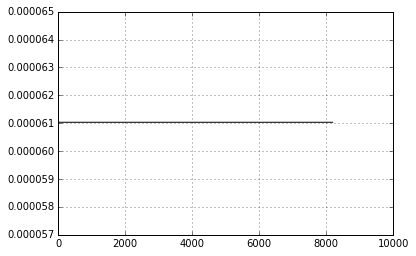

In [4]:
psd = read_psd_xmldoc( utils.load_filename("ZERO_DET_high_P.xml", contenthandler=series.LIGOLWContentHandler) )["H2"]

psd.data = 1.0/psd.data
# Not technically quite right number of samples
psd.data = numpy.concatenate((psd.data, [psd.data[-1]]))

# Comment out for full LIGO PSD
flat_psd = numpy.ones(len(psd.data)) * 2.0/len(psd.data)
psd.data = flat_psd

lal_psd = lal.CreateREAL8FrequencySeries("psd", lal.LIGOTimeGPS(psd.epoch), psd.f0, psd.deltaF, lal.Unit("strain"), len(psd.data))
lal_psd.data.data = psd.data

# FIXME: There's a lal function for calculating this correctly
corr = numpy.zeros(len(psd.data))
corr[0] = 1.0

freq = numpy.arange(psd.f0, len(psd.data)*psd.deltaF, psd.deltaF)
pyplot.plot(freq, psd.data, '-k')
pyplot.xlim([1e1, 1e4])
#pyplot.ylim([1e-47, 1e-43])
pyplot.grid()
#pyplot.loglog();

Let's create the filter bank. It spans the bandwidth from 16 Hz to 2 kHz in 4 Hz increments. It's important to note that the filter's total extent in Fourier space is actually twice the stated bandwidth (FWHM) and so the lowest 2 Hz and highest 2 Hz are unlikely to contribute.

In [5]:
_, fdb, lal_filters = create_filter_bank(psd.deltaF, 16, 4, 500, lal_psd, corr)

Convert all the frequency domain to the time domain for inspection.

In [6]:
tdb = []
for fdt in fdb:
    #print fdt.df, len(fdt), len(fdt) * fdt.df
    zero_padded = numpy.zeros(int((fdt.f0 / fdt.df).value) + len(fdt))
    st = int((fdt.f0 / fdt.df).value)

    zero_padded[st:st+len(fdt)] = numpy.real_if_close(fdt.value)
    
    # FIXME: why a factor of two for the zero padding?
    n_freq = int(2048 / fdt.df.value) * 2
    tdt = numpy.fft.irfft(zero_padded, n_freq) * math.sqrt(4096)
    tdt = numpy.roll(tdt, len(tdt)/2)

    tdt = TimeSeries(tdt, name="", epoch=fdt.epoch, sample_rate=1./dt)

    """
    check = tdt.fft()
    print check.df
    pyplot.plot(check.frequencies, numpy.abs(check), 'g-')
    pyplot.twinx()
    zp_freq = numpy.arange(len(zero_padded)) * fdt.df
    pyplot.plot(zp_freq, zero_padded, 'k-')
    pyplot.xlim(0, 64)
    break
    """
    
    tdb.append(tdt)

Plot a couple in the frequency and time domain.

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


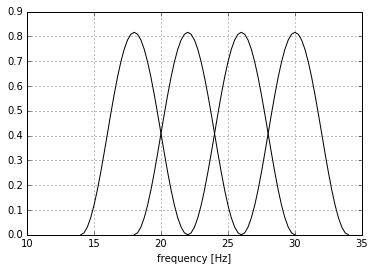

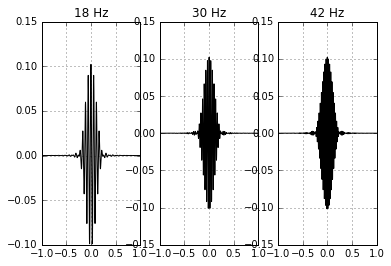

In [7]:
pyplot.figure()
for i, fdt in enumerate(fdb[:4]):
    freq = fdt.frequencies
    pyplot.plot(freq, fdt, 'k-')
pyplot.grid()
pyplot.xlabel("frequency [Hz]")

pyplot.figure()
for i, tdt in enumerate(tdb[:8:3]):
    pyplot.subplot(1, 3, i+1)

    pyplot.plot(tdt.times.value - 2, numpy.real_if_close(tdt.value), 'k-')
    #pyplot.ylim([-max(tdt), max(tdt)])
    pyplot.grid()
    c_f = 16 + 3 * (4*i) + 2
    pyplot.title("%d Hz" % c_f)
    pyplot.xlim(-1.0, 1.0)

Naively, one could infer the required duration of an FIR filter from the number of degrees of freedom:

$\text{NDOF}=2BD$

Since we produce (initially) tiles with 1 DOF, the duration goes as one over twice the bandwidth. However, the FD filters are actually twice as wide as the nominal FWHM, and so this number should be multiplied by ~2. In reality, the TD FIR filters produced are $4\Delta f/B$ long, four times as wide as necessary.

In practice, this could be accounted for by replacing the FD filters with those inverse FFTd from the time-domain truncated versions and contining with the remainder of the calculation. However, it's not clear if the higher bandwidth "virtual" filters would be viable --- the resultant window added together would not be a Tukey window with uniform response over the intended bandwidth.

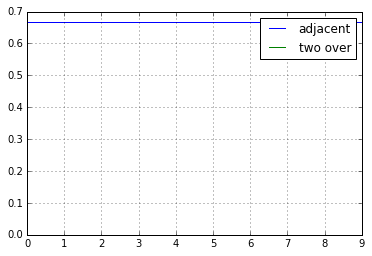

In [8]:
# Plot overlap of a few of the adjacent filters
ovrlp_ad, ovrlp_2ad = [], []
for i in range(10):
    ovrlp_ad.append(max(numpy.convolve(tdb[i], tdb[i+1])))
    ovrlp_2ad.append(max(numpy.convolve(tdb[i], tdb[i+2])))

pyplot.plot(ovrlp_ad, label='adjacent')
pyplot.plot(ovrlp_2ad, label='two over')
pyplot.legend()
pyplot.ylim([0, None])
pyplot.grid();

Let's try the explicit case of a simulated waveform (WNB) which is exactly centered in the band, and has a similar shape.

For reference, from the S6/VSR2/VSR3 burst all-sky paper () gives the following definitions for a SineGaussian waveform:

\begin{eqnarray}
h_+(t) = \sin(2\pi f_0 t)\exp\left( -\frac{t^2}{\tau^2}\right) \\
h_{\times}(t) = \cos(2\pi f_0 t)\exp\left( -\frac{t^2}{\tau^2}\right)
\end{eqnarray}

with $\tau=\frac{q}{\sqrt{2}\pi f_0}$. 

Taking the definition of the Fourier transform of a Gaussian to be:

\begin{equation}
\mathcal{F}\left(\exp(-\alpha t^2)\right) \rightarrow \exp(-\pi^2 f^2/\alpha)
\end{equation}

If, we instead express the Fourier domain gaussian as 

\begin{equation}
\exp(-f^2/B^2)
\end{equation}

where $B$ is the bandwidth (FWHM) of the Hann window filter. We equate $B^2 = \alpha/\pi^2 = 1 / \tau^2\pi^2$

So finally,

\begin{equation}
B^2 = \frac{2 f_0^2}{q^2}
\end{equation}

This fixes the value of $q$ to be:

\begin{equation}
q^2 = \frac{2f_0^2}{B^2}
\end{equation}

In [9]:
f_0 = 18
# FIXME: Is that factor of 2 from the full bandwidth of the filter?
q = math.sqrt(2)*f_0/filter_band * 2
print q
print SimBurstSineGaussianDuration(q, f_0)

12.7279220614
0.11253953952


0.000244140625 s 4096.0 Hz
0.000244140625 s 4096.0 Hz


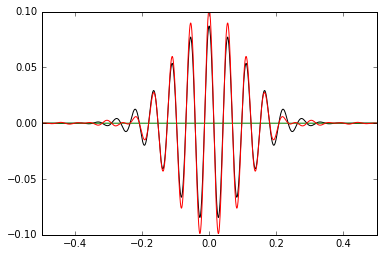

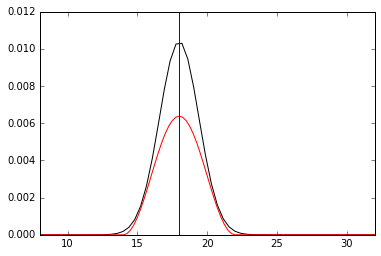

In [10]:
hp, hx = SimBurstSineGaussian(q, f_0, 0.0275, 1, 0, 1.0/4096)
hp = TimeSeries.from_lal(hp)
hx = TimeSeries.from_lal(hx)

print hp.dt, hp.sample_rate
pyplot.plot(hp.times, hp, 'k-')
pyplot.plot(hx.times, hx, 'g-');

print tdb[0].dt, tdb[0].sample_rate
pyplot.plot(tdb[0].times - tdb[0].times[-1]/2, tdb[0], 'r')
pyplot.xlim([-0.5, 0.5])
pyplot.ylim([-0.1, 0.1]);

hp_fd = numpy.abs(hp.fft())
fdt = numpy.abs(tdb[0].fft())
pyplot.figure()
pyplot.plot(hp_fd.frequencies, hp_fd, 'k-')
pyplot.plot(fdt.frequencies, fdt, 'r')
pyplot.axvline(f_0)
pyplot.xlim(8, 32);

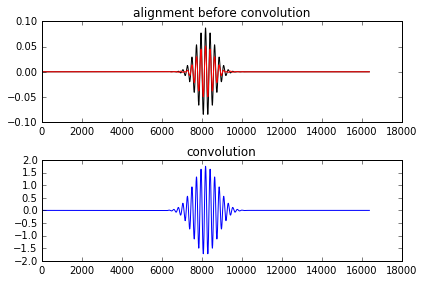

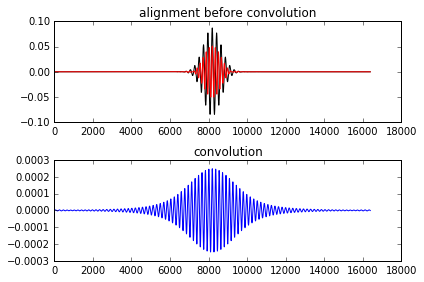

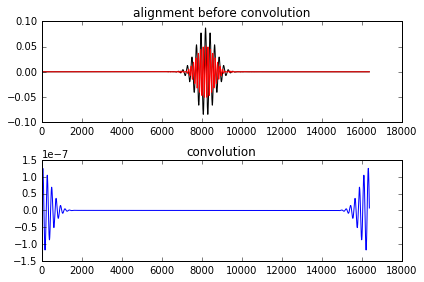

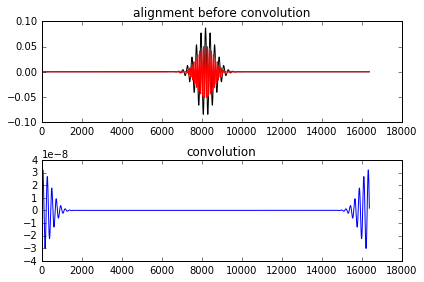

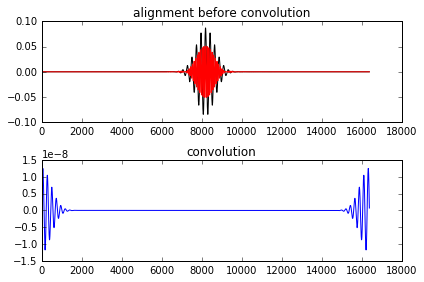

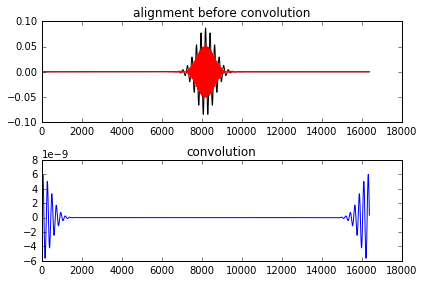

In [11]:
hp, hx = SimBurstSineGaussian(q, f_0, 0.0275, 1, 0, 1.0/4096)

# Zero pad the signal to be the same length as the filter
signal = hp.data.data
tmp = numpy.zeros(len(tdb[0]))
tmp[:len(signal)] = signal
signal = tmp

i = 1
for td_filter_cpy in tdb[:11:2]:
    td_filter = td_filter_cpy.copy()
    td_filter /= numpy.sqrt(numpy.dot(td_filter, td_filter))

    # Roll the signal so that it's better aligned, visually
    roll_idx = numpy.abs(signal).argmax() - numpy.abs(td_filter).argmax()
    signal = numpy.roll(signal, -roll_idx)

    pyplot.figure()
    pyplot.subplot(2, 1, 1)
    pyplot.title("alignment before convolution")
    pyplot.plot(signal, 'k-')
    pyplot.plot(td_filter, 'r-')
    #pyplot.xlim(6500, 10000)

    pyplot.subplot(2, 1, 2)
    pyplot.title("convolution")
    conv = numpy.convolve(td_filter, signal, "same")
    #pyplot.plot(numpy.roll(conv, len(conv)/2))
    pyplot.plot(conv, label="%d" % i)
    pyplot.tight_layout()
    
    # Uncomment to see log width of signal vs template
    #pyplot.figure()
    #pyplot.title("alignment before convolution")
    #pyplot.plot(numpy.abs(signal), 'k-')
    #pyplot.plot(numpy.abs(td_filter), 'r-')
    #pyplot.semilogy()

## Building Wider Bandwidth Filters

The filter normalization coefficients (from https://dcc.ligo.org/DocDB/0088/T1200125/001/power.pdf) are proptional to the following:

\begin{equation}
\mu_i^2(nb) = \frac{nb}{\Delta f} + 2\sum_{j,j'} \left\{ \Theta_{i,j}\Theta_{i,j'} \right\}
\end{equation}

And thus, to first order are always proportional to $\frac{nb}{\Delta f}$.

In [12]:
for i in range(3):
    nc = 2**i
    mu_sq = compute_channel_renomalization(nc, lal_filters[:5], corr, verbose=True)

    print nc*filter_band, nc*filter_band/psd.deltaF
    #print mu_sq
    print mu_sq[nc-1::nc]
    print numpy.average(mu_sq), numpy.std(mu_sq)

Calculating renormalization for resolution level containing 1 4.000000 Hz channels...  done.
4.0 16.0
[ 16.  16.  16.  16.  16.]
16.0 0.0
Calculating renormalization for resolution level containing 2 4.000000 Hz channels...  done.
8.0 32.0
[ 37.33333333  37.33333333]
34.1333333333 2.61278905897
Calculating renormalization for resolution level containing 4 4.000000 Hz channels...  done.
16.0 64.0
[ 80.]
67.2 6.4


(100, 100)
Calculating renormalization for resolution level containing 1 4.000000 Hz channels...  done.
(50, 100)
Calculating renormalization for resolution level containing 2 4.000000 Hz channels...  done.
(25, 100)
Calculating renormalization for resolution level containing 4 4.000000 Hz channels...  done.
(12, 100)
Calculating renormalization for resolution level containing 8 4.000000 Hz channels...  done.


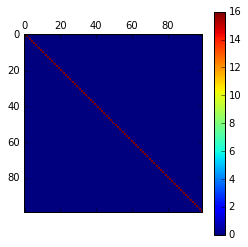

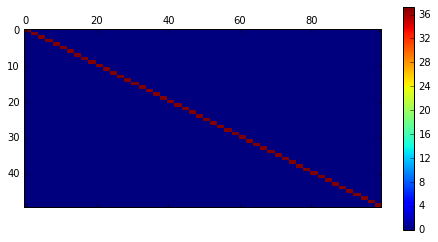

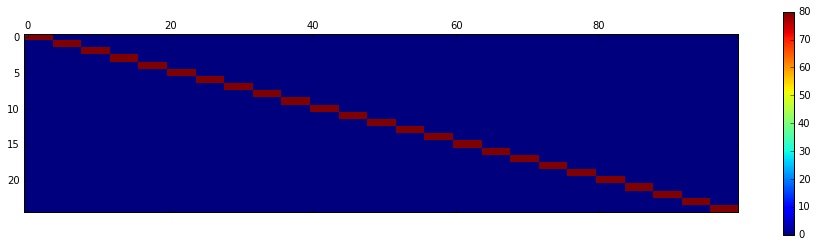

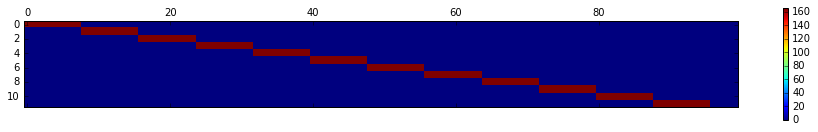

In [13]:
for i in range(4):
    nc = 2**i
    cmat = numpy.zeros((len(lal_filters[:100])/nc, len(lal_filters[:100])))
    print cmat.shape
    mu_sq = compute_channel_renomalization(nc, lal_filters[:100], corr, verbose=True)
    for row, val in enumerate(mu_sq[nc-1::nc]):
        st, en = nc * row, nc * (row+1)
        cmat[row,st:en] = val
    
    pyplot.figure(figsize=(8,8))
    pyplot.matshow(cmat, aspect='equal')
    pyplot.colorbar()

## Build a wide filter manually

The sum of adjacent filters produces a filter which is wider in bandwidth (by a factor of ~the number of summed filters). The narrowest filters' shape is chosen such that the sum of them produces a filter with identical response across all spanned frequency components (edges notwithstanding).

Note that this *won't* work in the case that we have a non-flat PSD because the filters have the shape of the PSD imposed on them. For smoothly and mildly varying PSDs and narrow filter bandwidths, this isn't noticeable until you get to this point, though. That's the whole point behind the small corrections to the normnalizations. If they were all straight Hann windows, we could calculate the normalization analytically and be done.

In practice, we never **actually** construct these filters. We infer their outputs from the combinations of the narrowest filters. This is efficient and a reasonable approximation to just doing the full analysis.

56 14.0 Hz
72 18.0 Hz
88 22.0 Hz
104 26.0 Hz


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


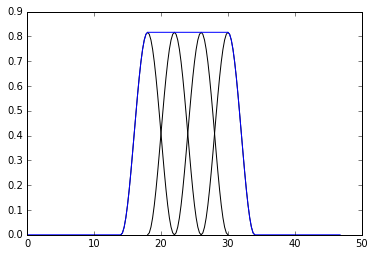

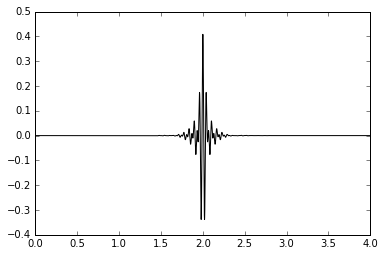

In [14]:
nsum = 4

# Let's plot the result in FD as well
pyplot.figure()

filter_size = fdb[0].f0 / fdb[0].df + len(fdb[0]) * nsum
wide_filter = numpy.zeros(filter_size)

flow = 16
for i, fdt in enumerate(fdb[:nsum]):
    st = int((fdt.f0 / fdt.df).value)
    print st, st * fdt.df
    pyplot.plot(fdt.frequencies, fdt, 'k-')
    wide_filter[st:st+len(fdt)] += numpy.real_if_close(fdt.value)

wide_filter = Spectrum(wide_filter, df=fdb[0].df)
pyplot.plot(wide_filter.frequencies, wide_filter, 'b-')
    
# FIXME: why a factor of two for the zeor padding?
n_freq = int(2048 / fdb[0].df.value) * 2
tdt = numpy.fft.irfft(wide_filter, n_freq) * math.sqrt(4096)
tdt = numpy.roll(tdt, len(tdt)/2)

dt = 1.0/4096.
tdt = TimeSeries(tdt, name="", epoch=fdt.epoch, sample_rate=1./dt)

pyplot.figure()
pyplot.plot(tdt.times, tdt, 'k-')

## Doing a 'real' analysis

Let's bury a signal in the data and see if we can retrieve it.

### Coloring Data

We have to generate some data with the noise profile that we've got above (else the rest of this analysis will inconsistent --- we've used the PSD to generate all out filters.

This process is called 'coloring' the data because it's the inverse operation of whitening.

> If you're using the flat PSD, then the whitening/coloring procedure is equivalent to scaling each frequency component, since Gaussian data is already flat in the frequency domain.

6.02311463655e-05 6.10332936617e-05


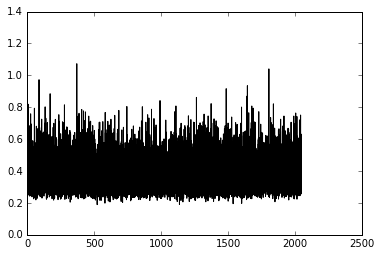

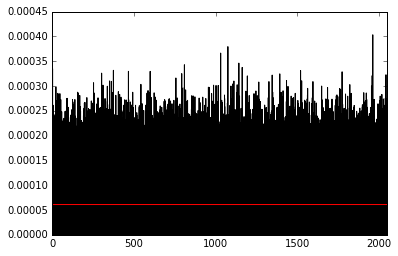

In [15]:
data_len_sec = 64. # s
data_dt = 1.0/4096
white_data = numpy.random.normal(0, 1, int(data_len_sec / data_dt))

white_data = TimeSeries(white_data, sample_rate=1.0/data_dt, epoch=0.0, unit="strain")
wdata_psd = white_data.psd(16, 8)

transfer = numpy.sqrt(psd.data / wdata_psd)
transfer.override_unit(None)
#print transfer.shape, transfer.df, wdata_psd.df, psd.deltaF

pyplot.figure()
pyplot.plot(transfer.frequencies, transfer, 'k-')

#cdata = white_data.whiten(4, 2, asd=1.0/transfer)
wdata_fd = white_data.fft()
# We have to downsample the transfer function, sadly
from scipy.interpolate import interp1d
transfer_us = interp1d(transfer.frequencies, transfer)(wdata_fd.frequencies)
wdata_fd *= transfer_us
cdata = wdata_fd.ifft()
cdata.override_unit("strain")

pyplot.figure()
cdata_psd = cdata.psd()
pyplot.plot(cdata_psd.frequencies, cdata_psd, 'k-')
psd_f = numpy.arange(psd.data.shape[0]) * psd.deltaF
pyplot.plot(psd_f, psd.data, 'r-')
pyplot.xlim(0, 2048)
# Check that the spectrum average is consistent with the input. Note, in general, non-flat PSDs will not respect this.
print numpy.average(cdata_psd), psd.data[0]

### Generate a signal to fit one of our band filters

We're going to make things easy at first, the signal will almost exactly match one of our narrow filters.

4.0 38.0
0.000244140625 s 4096.0 Hz
0.000244140625 s 4096.0 Hz
31.6934153165
125231 134402
strain strain


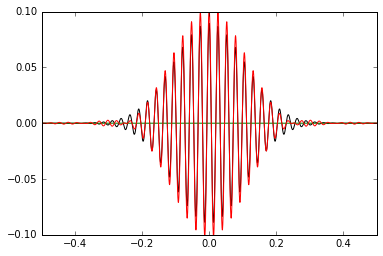

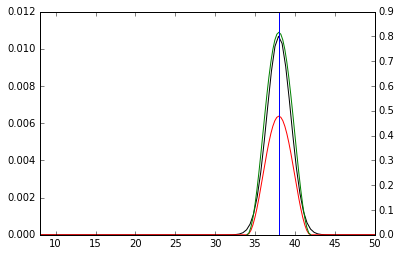

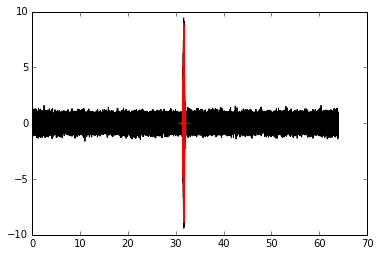

In [16]:
f_0 = fdb[5].f0.value + filter_band
print filter_band, f_0

hp, hx = SimBurstSineGaussian(q * 2, f_0, 0.0275, 1, 0, data_dt)
hp = TimeSeries.from_lal(hp)
hx = TimeSeries.from_lal(hx)

print hp.dt, hp.sample_rate
pyplot.plot(hp.times, hp, 'k-')
pyplot.plot(hx.times, hx, 'g-');

print tdb[5].dt, tdb[5].sample_rate
pyplot.plot(tdb[5].times - tdb[5].times[-1]/2, tdb[5], 'r')
pyplot.xlim([-0.5, 0.5])
pyplot.ylim([-0.1, 0.1]);

hp_fd = numpy.abs(hp.fft())
fdt = numpy.abs(tdb[5].fft())
pyplot.figure()
pyplot.plot(hp_fd.frequencies, hp_fd, 'k-')
pyplot.plot(fdt.frequencies, fdt, 'r')
pyplot.twinx()
pyplot.plot(fdb[5].frequencies, fdb[5], 'g')
pyplot.axvline(f_0)
pyplot.xlim(8, 50);

# and add it into the data, away from the edges
sig_dur_samp = len(hp)
sig_dur_s = len(hp) * hp.dt
random_time = 32 + numpy.random.uniform(-2, 2)
print random_time
rtime_samp = int(random_time / data_dt) - sig_dur_samp/2
st, en = rtime_samp, rtime_samp + sig_dur_samp
print st, en

hp.epoch = random_time - sig_dur_s.value/2

# We rescale the amplitude to hide or expose it in the data a bit better
amp = 1e2

hp *= amp
print hp.unit, cdata.unit
# We make a copy in case we need cdata later. Spoiler alert: we will.
cdata_cpy = cdata.copy()
cdata_cpy[st:en] += hp

pyplot.figure()
pyplot.plot(cdata_cpy.times, cdata_cpy, 'k-')
pyplot.plot(hp.times, hp, 'r-')

## Whiten the data

Whitened data should be zero-mean, unit variance Gaussian random variables. Now, that's what we started with so whitening should produce very similar looking data

-4.44522890719e-17 1.40369302343


(0, 10)

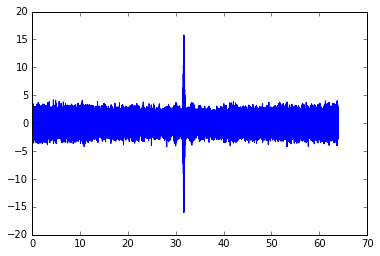

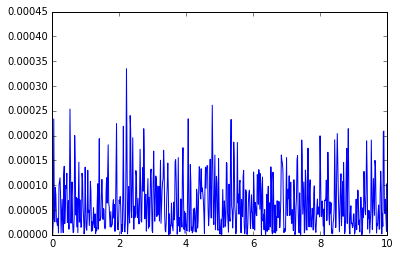

In [17]:
#cdata = white_data.whiten(4, 2, asd=1.0/transfer)
#cdata_fd = cdata.fft()
#cdata_fd /= numpy.sqrt(cdata_psd)
#cdata_cpy = cdata_fd.ifft()

# whiten must be missing a factor of dt -- there's also a large DC offset that we just blow away
cdata_psd_tmp = cdata_psd.copy()
cdata_psd_tmp[:3] /= u.Quantity(10, u.dimensionless_unscaled)
cdata_whitened = cdata_cpy.whiten(64, 32, asd=numpy.sqrt(cdata_psd_tmp), window='boxcar') * 1/data_dt/4
cdata_whitened.override_unit(None)

print numpy.mean(cdata_whitened), numpy.std(cdata_whitened)**2

pyplot.plot(cdata_whitened.times, cdata_whitened)
#pyplot.plot(cdata.times, cdata)
pyplot.figure()
pyplot.plot(cdata_psd_tmp.frequencies, cdata_psd_tmp);
pyplot.xlim(0, 10)

### Filter the data

We have to first properly normalize our filters, then convolve.

Once the convolution is done, then we "undersample" the data. This is done because the ouput data streams are oversampled. You can understand this is the following way:

  * The filters have an effective bandwidth of $B$, regardless of their frequency
  * We are, in effect, band passing the data around those frequencies
  * If we demodulated the data, then all information would be brought down to $f \in [0, B]$, but at a higher sampling rate than is necessary.
  * Undersampling accomplishes the "basebanding" without need for demodulation --- the only trick is that we need to keep twice as many samples as one expects because the filter is only a single degree of freedom. The second degree of freedom is still present, but we have to sum over two independent samples. This is equivalent to summing over the sine and cosine squared.

1.08355361794
1.16248433334
1.35285942762
1.07506823075
7.07987232787
39.3919843291
6.79821776544
1.02672820323
1.11547565694
0.982188553796


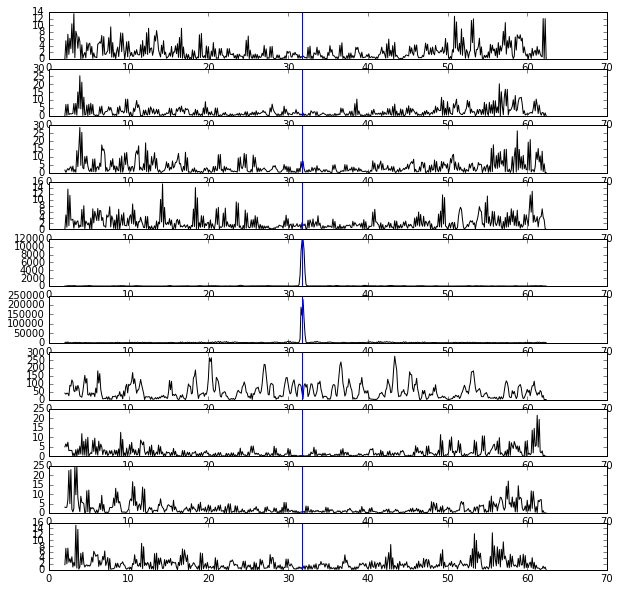

In [18]:
nchan = 10
nc_sum = 1

bins = numpy.linspace(0, 40, 100)
cnt = numpy.zeros(bins.shape[0]-1)

for i, tdf in enumerate(tdb[:nchan]):
    us_rate = int(1.0 / (2 * filter_band*nc_sum * cdata_cpy.dt.value))
    #print us_rate * cdata_cpy.dt.value
    pyplot.figure(0, figsize=(10, 10))
    pyplot.subplot(nchan, 1, i+1)
    # FIXME: normalization seems off...
    #fil = tdf / numpy.sqrt(band/fdb[0].df)
    fil = tdf #* (band/fdb[0].df)
    snr_1dof = numpy.convolve(fil, cdata_whitened, "valid")
    print numpy.std(snr_1dof)
    
    # Undersample the data --- there's a lot of redundant information
    #print us_rate
    snr_1dof = snr_1dof[::us_rate]**2
    
    # Sum semi-adjacent samples to get 2 DOF tiles
    snr_2dof = numpy.convolve(snr_1dof, numpy.array([1, 0, 1, 0]))
    t = TimeSeries(snr_2dof, epoch=cdata_whitened.epoch, sample_rate=int(1.0/(us_rate * cdata_cpy.dt.value)))
    pyplot.plot(t.times + len(tdf)/2 * tdf.dt, snr_2dof, 'k-')
    pyplot.axvline(random_time)
    tmp, _ = numpy.histogram(snr_2dof, bins=bins)
    cnt += tmp

# Uncomment for a histogram of the samples --- in Gaussian noise, these should \chi^2 distributed with k = 2 degrees
# of freedom
# NOTE: There's a fudge factor here which is empirical. Since the filters overlap in frequency space the statistical
# sampling of energies is correlated, and the number of degrees of freedom is reduced by this empirical factor to
# account for it.

#pyplot.figure(1)
#pyplot.plot(bins, scipy.stats.chi2(2 * 0.65).pdf(bins), 'r-')
#dx = bins[1] - bins[0]
#pyplot.plot(bins[:-1], cnt/float(sum(cnt) * dx), 'g-')
#pyplot.semilogx();

### Exercise

This signal was blazingly loud. You should try ramping the amplitude down and watch how the signal disappears into the noise fluctuations after a while.

### Let's try something a little harder

A Band and Time limited White Noise Burst (BTLWNB) are effectively random bursts of power confined to a bandwidth and duration. The Sine-Gaussians we've been using previously are limited to two degrees of freedom: that is to say they have a fixed area in the time-frequency plane, and that area is ~2 in dimensionless units.

BTLWNB can have as many DOF as one likes. Choosing the duration and bandwidth sets the degrees of freedom, and an intrinsic amplitude sets the signal to noise ratio.

producing a 0.500000 s x 16.000000 Hz signal, centered at 30.000000 Hz
0.000244140625 s 4096.0 Hz
30.8906752715
105024 148033
strain strain


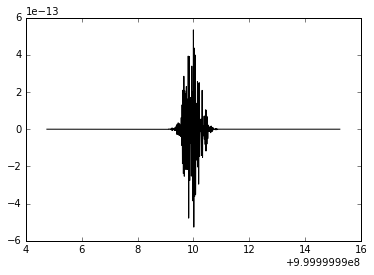

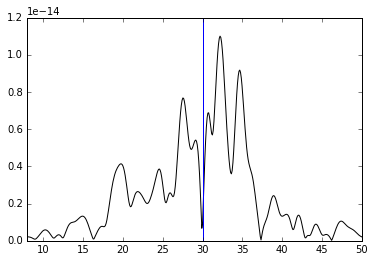

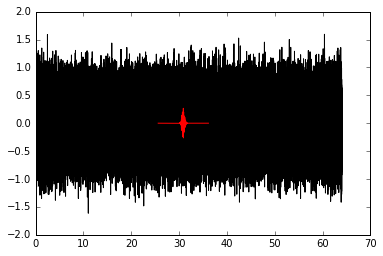

In [19]:
dof = 16
wnb_band = 4 * filter_band # four narrow bandwidths long (16 Hz)
dur = dof / 2 / wnb_band
f_0 = fdb[4].f0.value # central frequency
print "producing a %f s x %f Hz signal, centered at %f Hz" % (dur, wnb_band, f_0)

hp = generate_wnb(dur, wnb_band, f_0, 1.0, dt=data_dt, rnd=0)

print hp.dt, hp.sample_rate
pyplot.plot(hp.times, hp, 'k-')

#print tdb[5].dt, tdb[5].sample_rate
#pyplot.plot(tdb[5].times - tdb[5].times[-1]/2, tdb[5], 'r')
#pyplot.xlim([-0.5, 0.5])
#pyplot.ylim([-0.1, 0.1]);

hp_fd = numpy.abs(hp.fft())
fdt = numpy.abs(tdb[5].fft())
pyplot.figure()
pyplot.plot(hp_fd.frequencies, hp_fd, 'k-')
#pyplot.plot(fdt.frequencies, fdt, 'r')
pyplot.axvline(f_0)
pyplot.xlim(8, 50);

# and add it into the data, away from the edges
sig_dur_samp = len(hp)
sig_dur_s = len(hp) * hp.dt
random_time = 32 + numpy.random.uniform(-2, 2)
print random_time
rtime_samp = int(random_time / data_dt) - sig_dur_samp/2
st, en = rtime_samp, rtime_samp + sig_dur_samp
print st, en

hp.epoch = random_time - sig_dur_s.value/2

# We rescale the amplitude to hide it in the data a bit better
amp = 5e11 # Note the scaling here is stranger than SG because it's relative to a physical scale which is hidden

hp *= amp
print hp.unit, cdata.unit

# We also have to reset the data, since it has a signal in it from before
cdata_cpy = cdata.copy()
cdata_cpy[st:en] += hp

pyplot.figure()
pyplot.plot(cdata_cpy.times, cdata_cpy, 'k-')
pyplot.plot(hp.times, hp, 'r-')

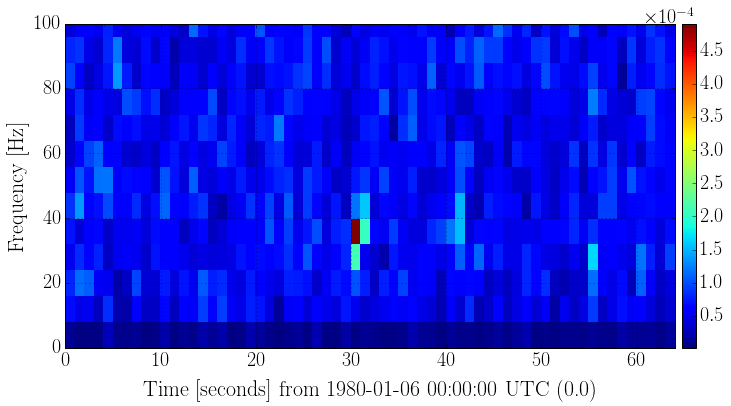

In [20]:
# Let's see if we can get a spectrogram too
from gwpy.plotter import SpectrogramPlot
spec = cdata_cpy.spectrogram(1, 0.125)
plt = SpectrogramPlot()
ax = plt.gca()
ax.plot(spec)
ax.set_ylim(0, 100)
plt.add_colorbar();

## Wide band filtered analysis

We can redo the analysis that we did before for the SG, but in this case, the filter is not optimal for the signal. We could generate the wider band filter and use that, but this isn't efficient as we'd have to generate a filter comb that spanned frequencies that were very dense in the frequency space and the convolution time would kill us. We **can** construct the 'virtual' filters that correspond to a combination of the narrow band filters --- this means we don't need the wide band filters or their output.

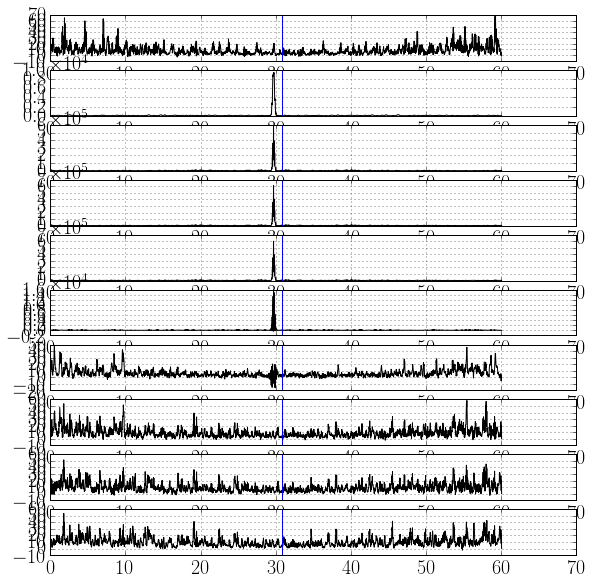

In [21]:
nchan = 10
nc_sum = 4

bins = numpy.linspace(0, 40, 100)
cnt = numpy.zeros(bins.shape[0]-1)

for i, tdf in enumerate(tdb[:nchan]):
    us_rate = int(1.0 / (2 * filter_band*nc_sum * cdata_cpy.dt.value))
    #print us_rate * cdata_cpy.dt.value
    pyplot.figure(0, figsize=(10, 10))
    pyplot.subplot(nchan, 1, i+1)
    snr_ndof = numpy.convolve(tdf, cdata_whitened, "valid")[::us_rate]
    for j in range(i+1, i+nc_sum):
        snr_ndof += numpy.convolve(tdb[j], cdata_whitened, "valid")[::us_rate]**2
    
    # Sum semi-adjacent samples to get 2 DOF tiles
    snr_2ndof = numpy.convolve(snr_ndof, numpy.array([1, 0, 1, 0]))
    t = TimeSeries(snr_2ndof, epoch=cdata_whitened.epoch, sample_rate=int(1.0/(us_rate * cdata_cpy.dt.value)))
    pyplot.plot(t.times, snr_2ndof, 'k-')
    pyplot.axvline(random_time)
    tmp, _ = numpy.histogram(snr_2ndof, bins=bins)
    cnt += tmp

# Uncomment for a histogram of the samples --- in Gaussian noise, these should \chi^2 distributed with k = 2 degrees
# of freedom
# NOTE: There's a fudge factor here which is empirical. Since the filters overlap in frequency space the statistical
# sampling of energies is correlated, and the number of degrees of freedom is reduced by this empirical factor to
# account for it.

#pyplot.figure(1)
#pyplot.plot(bins, scipy.stats.chi2(dof * 0.65).pdf(bins), 'r-')
#dx = bins[1] - bins[0]
#pyplot.plot(bins[:-1], cnt/float(sum(cnt) * dx), 'g-')
#pyplot.semilogx();

### Exercise

You can try the following:

 * Do the same analysis for the WNB that we did for the SG (e.g. *don't* create the virtual wide channels) and see how much one loses
 * Instead of increasing the bandwidth of the BTLWNB, increase its duration.
   * Think about how to compensate for this in the analysis